In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import resample
from scipy.stats import mode

from config import Config

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
data_dir = "../../../data/dataset/raw/"
subjects = os.listdir(data_dir)
gestures = Config.GESTURES
learning_rate = 3e-4

test_subject = "007"

In [3]:
def __pre_process_recording(data: pd.DataFrame) -> pd.DataFrame:
    data.drop(columns=["time"], inplace=True)
    data.drop(0, inplace=True)  # Remove first All-0 row
    return data - data.iloc[:10].median()  # Initial position correction

In [4]:
train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for subject in subjects:
    for gesture in Config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            file_path = os.path.join(gesture_dir, recording)
            data = pd.read_csv(file_path)
            # data.drop(columns=["time"], inplace=True)
            data = __pre_process_recording(data)
            data = data.apply(resample, args=(Config.SEGMENT_LEN, None, 0))
            
            for_training = subject != test_subject

            # # ... Distance to thumb finger-tip
            # data["drf0"] = np.sqrt(
            #     np.square(data["rf0x"] - data["rpx"]) +
            #     np.square(data["rf0z"] - data["rpz"])
            # )

            # # ... Distance to index finger-tip
            # data["drf1"] = np.sqrt(
            #     np.square(data["rf1x"] - data["rpx"]) +
            #     np.square(data["rf1z"] - data["rpz"])
            # )

            # # ... Distance to middle finger-tip
            # data["drf2"] = np.sqrt(
            #     np.square(data["rf2x"] - data["rpx"]) +
            #     np.square(data["rf2z"] - data["rpz"])
            # )

            # # ... Thumb coordineates wrt palm (for determining orientation)
            # data["drf0x"] = data["rf0x"] - data["rpx"]
            # data["drf0z"] = data["rf0z"] - data["rpz"]

            # Features v1.0
            data["drf0x"] = data["rf0x"] - data["rpx"]
            data["drf0y"] = data["rf0y"] - data["rpy"]
            data["drf0z"] = data["rf0z"] - data["rpz"]

            data["drf1x"] = data["rf1x"] - data["rpx"]
            data["drf1y"] = data["rf1y"] - data["rpy"]
            data["drf1z"] = data["rf1z"] - data["rpz"]

            data["label"] = Config.GESTURES.index(gesture)

            if for_training:
                train_dataset = pd.concat([train_dataset, data])
            else:
                test_dataset = pd.concat([test_dataset, data])

train_dataset.reset_index(inplace=True)
test_dataset.reset_index(inplace=True)

print(train_dataset.shape)
print(test_dataset.shape)

(149700, 44)
(24150, 44)


In [5]:
# diff_features = train_dataset[Config.DIFF_FEATURES]
# dist_features = train_dataset[Config.DIST_FEATURES]

# # dist_features = dist_features / dist_features.max(axis=0)

# features = pd.concat([dist_features, diff_features], axis=1)
# features

# Scaler Metrics

In [6]:
# features = train_dataset[Config.DIST_FEATURES]

In [7]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(features)
# print(scaler.data_min_)
# print(scaler.data_max_ - scaler.data_min_)

In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(features)

# print(scaler.mean_)
# print(np.sqrt(scaler.var_))

In [9]:
train_features = train_dataset[Config.INFERENCE_FEATURES + ["label"]]
test_features = test_dataset[Config.INFERENCE_FEATURES + ["label"]]
train_features

,rpx,rpy,rpz,label
0,-3.812357,-8.057452,5.240843,0
1,1.002518,2.115327,-1.358159,0
2,-0.544964,-1.122305,0.740645,0
3,0.367240,0.725148,-0.504207,0
4,-0.277008,-0.592802,0.356569,0
...,...,...,...,...
149695,-8.208508,37.130129,17.663796,13
149696,-7.852542,35.672697,16.935784,13
149697,-8.266356,37.528537,17.785945,13
149698,-7.681733,34.959156,16.569401,13


In [10]:
import tensorflow as tf

from tensorflow.keras import layers, models, losses, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [11]:
scaler = MinMaxScaler()
# X = features.drop(columns=["label"]).to_numpy()
# X = scaler.fit_transform(X)
# X = X.reshape((-1, Config.SEGMENT_LEN, len(Config.INFERENCE_FEATURES)))
# y = features["label"].to_numpy().reshape((-1, Config.SEGMENT_LEN))
# y, _ = mode(y, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42
# )

X_train = train_features.drop(columns=["label"]).to_numpy()
X_test = test_features.drop(columns=["label"]).to_numpy()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((-1, Config.SEGMENT_LEN, len(Config.INFERENCE_FEATURES)))
X_test = X_test.reshape((-1, Config.SEGMENT_LEN, len(Config.INFERENCE_FEATURES)))

y_train = train_features["label"].to_numpy().reshape((-1, Config.SEGMENT_LEN))
y_test = test_features["label"].to_numpy().reshape((-1, Config.SEGMENT_LEN))

y_train, _ = mode(y_train, axis=1)
y_test, _ = mode(y_test, axis=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(998, 150, 3)
(161, 150, 3)
(998, 1)
(161, 1)


In [12]:
def conv_block_1d():
    inputs = layers.Input(shape=(Config.SEGMENT_LEN, 1))
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv1D(8, 3, activation="selu")(x)
    x = layers.Conv1D(8, 3, activation="selu")(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(8, 3, activation="selu")(x)
    x = layers.Conv1D(8, 3, activation="selu")(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(16, 3, activation="selu")(x)
    x = layers.Conv1D(16, 3, activation="selu")(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(16, 3, activation="selu")(x)
    x = layers.Conv1D(16, 3, activation="selu")(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Flatten()(x)
    output = layers.Dense(64)(x)

    return inputs, output

def get_model(n_channels: int):
    inputs = []
    features = []

    for _ in range(n_channels):
        input_1d, features_1d = conv_block_1d()
        inputs.append(input_1d)
        features.append(features_1d)

    x = layers.concatenate(features, axis=-1)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(len(gestures), activation="softmax")(x)

    return models.Model(inputs, output)

In [13]:
model = get_model(n_channels=len(Config.INFERENCE_FEATURES))

loss = losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=np.split(X_train, len(Config.INFERENCE_FEATURES), axis=-1),
    y=y_train,
    validation_data=(
        np.split(X_test, len(Config.INFERENCE_FEATURES), axis=-1),
        y_test
    ),
    batch_size=32,
    epochs=300,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/300
32/32 [==============================] - 2s 21ms/step - loss: 2.9016 - accuracy: 0.1012 - val_loss: 2.6359 - val_accuracy: 0.0745
Epoch 2/300
32/32 [==============================] - 0s 9ms/step - loss: 2.5055 - accuracy: 0.1653 - val_loss: 2.5754 - val_accuracy: 0.1056
Epoch 3/300
32/32 [==============================] - 0s 9ms/step - loss: 2.3758 - accuracy: 0.2024 - val_loss: 2.5185 - val_accuracy: 0.1801
Epoch 4/300
32/32 [==============================] - 0s 9ms/step - loss: 2.1976 - accuracy: 0.2675 - val_loss: 2.4153 - val_accuracy: 0.1988
Epoch 5/300
32/32 [==============================] - 0s 10ms/step - loss: 2.0499 - accuracy: 0.3096 - val_loss: 2.2947 - val_accuracy: 0.2671
Epoch 6/300
32/32 [==============================] - 0s 9ms/step - loss: 1.9209 - accuracy: 0.3667 - val_loss: 2.1449 - val_accuracy: 0.3851
Epoch 7/300
32/32 [==============================] - 0s 9ms/step - loss: 1.8201 - accuracy: 0.3918 - val_loss: 2.0758 - val_accuracy: 0.4472
Epoch 8/300

In [15]:
model.evaluate(np.split(X_test, len(Config.INFERENCE_FEATURES), axis=-1), y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.9592 - accuracy: 0.6957


[0.9592047929763794, 0.695652186870575]

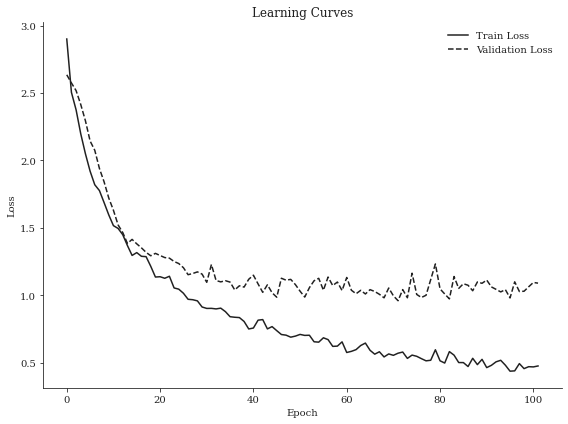

In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--", color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# tf.keras.backend.clear_session()

In [21]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

y_pred = np.argmax(model.predict(np.split(X_test, len(Config.INFERENCE_FEATURES), axis=-1)), axis=1)
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(f1_score(y_test, y_pred, average="macro"))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

6/6 [==============================] - 0s 3ms/step
0.7220565734655066
0.6833333333333335
0.6775178505366982
0.6956521739130435
              precision    recall  f1-score   support

           0       0.35      0.50      0.41        12
           1       0.67      0.67      0.67        12
           2       0.92      0.92      0.92        12
           3       1.00      0.67      0.80        12
           4       0.69      0.92      0.79        12
           5       1.00      0.75      0.86        12
           6       0.67      0.67      0.67        12
           7       0.77      0.83      0.80        12
           8       0.52      1.00      0.69        12
           9       0.67      0.17      0.27        12
          10       1.00      0.92      0.96        12
          11       0.29      0.40      0.33         5
          12       0.70      0.58      0.64        12
          13       0.88      0.58      0.70        12

    accuracy                           0.70       161
   macr

<AxesSubplot:>

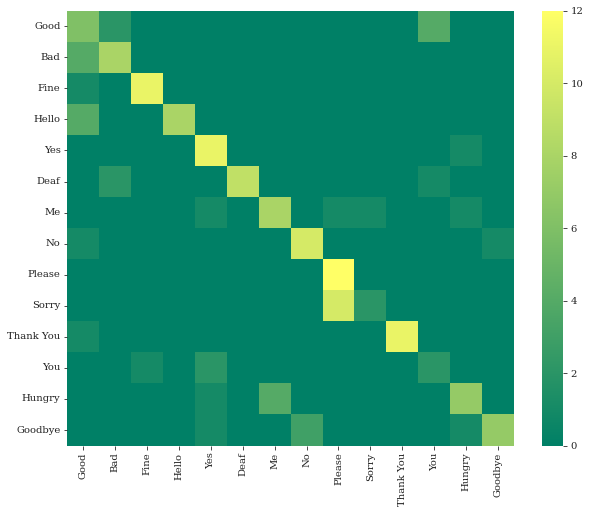

In [27]:
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=Config.GESTURES, yticklabels=Config.GESTURES, cmap="summer")

In [19]:
import joblib
joblib.dump(scaler, "../../../models/scaler.joblib")
model.save("../../../models/stack_cnn")

INFO:tensorflow:Assets written to: ../../../models/stack_cnn\assets


INFO:tensorflow:Assets written to: ../../../models/stack_cnn\assets
